# SHOW THE PD IN SF-SF-SF NETWORK

In [3]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import string

In [4]:
def reSaveData(mu_, lam_, N = 30):
    
    w1_list = np.linspace(0, 1, N).tolist()
    w2_list = np.linspace(0, 1, N).tolist()
    
    rho_0 = 0.17
    theta = 0.1
#     file_path = os.path.join(os.getcwd(), "data", f"RHO_N_mu{mu_}lam0.dat")
    
    file_path = os.path.join(os.getcwd(), "data", f"RHO_N_mu{mu_}grid{N}lam{lam_}.dat")
    
    result_new = pickle.load(open(file_path, "rb"))
    w1_mesh, w2_mesh = np.meshgrid(w1_list, w2_list)
    rho = np.zeros((N, N, 2))
    
    for i in range(N):
        for j in range(N):            
            rho[j, i, :] = result_new[i + j * N][0][0]
                       
    rho_Inf =  rho[:, :, :].mean(axis = 2).T
    
    file_pathNew = os.path.join(os.getcwd(), "AnalysisData", f"mu{mu_}lam{lam_}.h5")
    
    f = h5py.File(file_pathNew, 'w')
    
    f.create_dataset('w1', data = w1_list)
    f.create_dataset('w2', data = w2_list)
    f.create_dataset('rho', data = rho_Inf)
    f.create_dataset('rho_0', data = rho_0)
    f.create_dataset('theta', data = theta)
    f.create_dataset('Method', data = "TL approximation")        
    f.close()

# for lam_ in list([2.5, 3, 3.5]):
#     for mu_ in list([0.1, 0.5, 0.9]):
#         reSaveData(mu_, lam_, 30)

# fileLoc = r"dataNewStruc/mu0.2.h5"

# f = h5py.File(fileLoc, 'r')
# w1_ = f['w1'][()]
# w2_ = f['w2'][()]
# rho = f["rho"][()]

# ll = f["Method"][()]
    
# f.close()

In [5]:
reSaveData(0.1, 2.5, 30)
reSaveData(0.5, 2.5, 30)
reSaveData(0.9, 2.5, 30)


In [6]:
def plot_diagram(mu_, lam_, ax1):
    
    loc = os.path.join("AnalysisData", f"mu{mu_}lam{lam_}.h5")
    
    f= h5py.File(loc, 'r')
    
    w1_ = f["w1"][()]
    w2_ = f["w2"][()]
    rho = f["rho"][()]
    
#     theta = f["theta"][()]
#     rho_0 = f["rho_0"][()]
    
#     print(f"rho_0: {rho_0}, theta: {theta}")
    
    f.close()
       
    w1_mesh, w2_mesh = np.meshgrid(w1_, w2_)

    p1 = ax1.pcolor(w1_mesh, w2_mesh, rho, shading = 'auto', cmap='YlGnBu')
    p1.set_clim(0, 1)
#     plt.colorbar(p1, ax = ax1, label = r"$\rho_{\infty}$")
    ax1.tick_params(axis='both', which='major', labelsize=13)
    ax1.set_xticks([0.0, 0.5, 1.0])
    ax1.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
    
    ax1.set_xlabel(r"$\omega_{\mathrm{intra}}$", fontsize = 22)
    ax1.set_ylabel(r"$\omega_{\mathrm{inter}}$", fontsize = 22)
    plt.tight_layout()
       


In [7]:
def read_data_SM(w1, w2, mu = 0.15,  N = 100000, z = 20, theta = 0.1, rho = 0.17, lam_ = 3, len_ = 30):
    
    if int(w2) == w2: w2 = int(w2)
    if int(w1) == w1: w1 = int(w1)
    
    path = os.path.join("data", f"theta{theta}rho{rho}N{N}z{z}mu{mu}lam{lam_}", f"w1{w1}w2{w2}.out" )
#     path = os.path.join("dataS", f"w1{w1}w2{w2}.out" )
    
    lines = [x.rstrip() for x in open(path)]
    
    A = np.array([float(j) for i in range(len(lines)) for j in lines[i].split(" ")]) 
    B = A.reshape(-1, 2)
    return B[0:len_, :]

def save_simulationData(mu, lam_, step = 2.5, N = 100000, z =20, theta = 0.1, rho_0 = 0.17, len_ = 30):
    
    w1_list = np.arange(0, 101, step)/100
    w2_list = np.arange(0, 101, step)/100

    rho = np.zeros((len(w1_list), len(w2_list), len_, 2))

    for i in range(len(w1_list)):
        w1_ = w1_list[i]
        for j in range(len(w2_list)):
            w2_ = w2_list[j]        
            B = read_data_SM(w1_, w2_, mu = mu, N = N, z = z, theta = theta, rho = rho_0, lam_ = lam_, len_ = len_)        
            if B.shape[0] != len_: print("error")
            rho[i, j, :, :] = B
            
    rho_ = rho.mean(axis = (2,3)).T
    
    loc_ = os.path.join( "SimulationData", f"theta{theta}rho{rho_0}N{N}z{z}mu{mu}lam{lam_}.h5")
    
    f = h5py.File(loc_, 'w')
    
    f.create_dataset("w1", data = w1_list)
    f.create_dataset("w2", data = w2_list)
    f.create_dataset("rho", data = rho_)
    f.create_dataset("rho_origin", data = rho)
    
    f.close()


In [8]:
def plot_simu_diagram(mu, lam_, ax_, N = 100000):
    
    loc_ = os.path.join( "SimulationData", "theta0.1rho0.17N{}z20mu{}lam{}.h5")

    f = h5py.File(loc_.format(N, mu, lam_), 'r')
    w1_ = f['w1'][()]
    w2_ = f['w2'][()]
    rho_ = f["rho"][()]
    f.close()

    w1Mesh, w2Mesh = np.meshgrid(w1_, w2_)
#     fig, ax = plt.subplots(2,1,figsize = (4, 5.5),dpi = 150)
    pc = ax_.pcolor(w1Mesh, w2Mesh, rho_, shading = 'auto', cmap='YlGnBu')
    pc.set_clim(0, 1)
#     plt.colorbar(pc, ax = ax_)
    ax_.tick_params(axis='both', which='major', labelsize=13)
    ax_.set_xticks([0.0, 0.5, 1.0])
    ax_.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
    
    ax_.set_xlabel(r"$\omega_{\mathrm{intra}}$", fontsize = 22)
    ax_.set_ylabel(r"$\omega_{\mathrm{inter}}$", fontsize = 22)
#     ax_.text(0.7, .9, r"simulation")
    plt.tight_layout()
    
    return pc

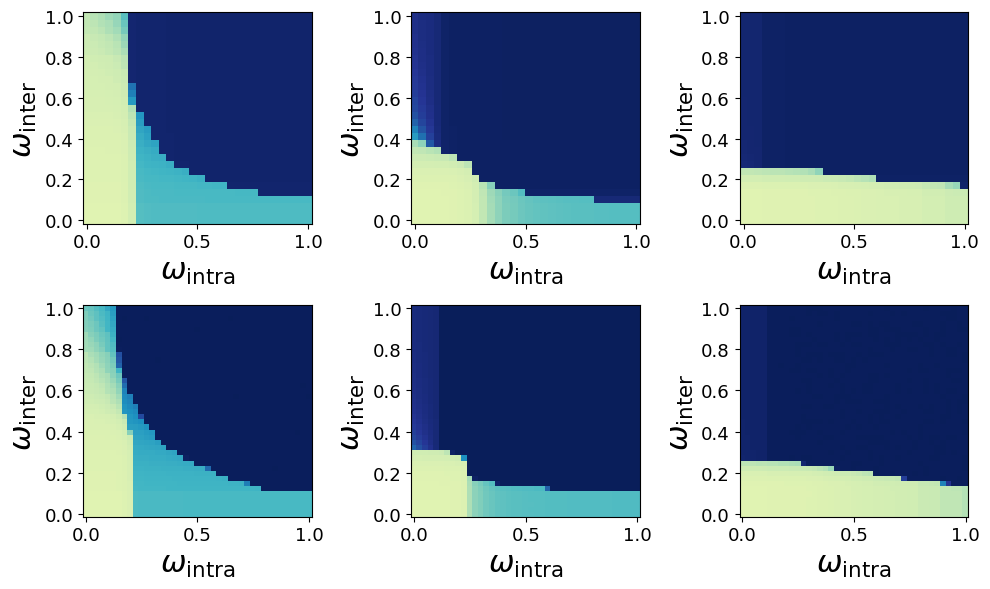

In [9]:
fig, ax = plt.subplots(2, 3, figsize = (10, 6), dpi = 100)

plot_simu_diagram(0.1, 2.5, ax[1, 0], N = 200000)
plot_simu_diagram(0.5, 2.5, ax[1, 1], N = 200000)
plot_simu_diagram(0.9, 2.5, ax[1, 2], N = 200000)

plot_diagram(0.1, 2.5, ax[0, 0])
plot_diagram(0.5, 2.5, ax[0, 1])
plot_diagram(0.9, 2.5, ax[0, 2])


## appendix SF-SF-SF $\lambda = 3.0$

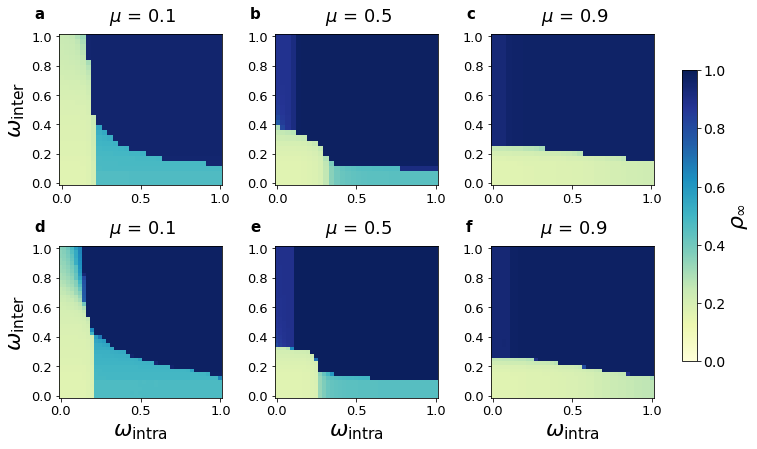

In [11]:
### 放论文附录Fig S6的是这个图
fig, ax1 = plt.subplots(2, 3, figsize = (12, 6))

pc1 = plot_diagram(0.1, 3.0, ax1[0, 0])
pc2 = plot_diagram(0.5, 3.0, ax1[0, 1])
pc3 = plot_diagram(0.9, 3.0, ax1[0, 2])

pc1 = plot_simu_diagram(0.1, 3, ax1[1, 0], N = 200000)
pc2 = plot_simu_diagram(0.5, 3, ax1[1, 1], N = 200000)
pc3 = plot_simu_diagram(0.9, 3, ax1[1, 2], N = 200000)


ax1[0, 0].text(0.3, 1.1, r"$\mu$ = 0.1", color = 'k', fontsize = 18)
ax1[0, 1].text(0.3, 1.1, r"$\mu$ = 0.5", color = 'k', fontsize = 18)
ax1[0, 2].text(0.3, 1.1, r"$\mu$ = 0.9", color = 'k', fontsize = 18)

ax1[1, 0].text(0.3, 1.1, r"$\mu$ = 0.1", color = 'k', fontsize = 18)
ax1[1, 1].text(0.3, 1.1, r"$\mu$ = 0.5", color = 'k', fontsize = 18)
ax1[1, 2].text(0.3, 1.1, r"$\mu$ = 0.9", color = 'k', fontsize = 18)

ax1[0, 0].annotate(r"a", (-0.15, 1.1), xycoords = 'axes fraction', fontsize = 15, fontweight='bold')
ax1[0, 1].annotate(r"b", (-0.15, 1.1), xycoords = 'axes fraction', fontsize = 15, fontweight='bold')
ax1[0, 2].annotate(r"c", (-0.15, 1.1), xycoords = 'axes fraction', fontsize = 15, fontweight='bold')
ax1[1, 0].annotate(r"d", (-0.15, 1.1), xycoords = 'axes fraction', fontsize = 15, fontweight='bold')
ax1[1, 1].annotate(r"e", (-0.15, 1.1), xycoords = 'axes fraction', fontsize = 15, fontweight='bold')
ax1[1, 2].annotate(r"f", (-0.15, 1.1), xycoords = 'axes fraction', fontsize = 15, fontweight='bold')

for i in range(2): # 遍历行
    for j in range(3): # 遍历列
        ax = ax1[i, j]
        if i == 0:
            ax.set_xlabel(None)
        if j > 0:
            ax.set_ylabel(None)

fig.subplots_adjust(hspace = 0.4, wspace = 0.32, left = 0.13)
    
pc = fig.colorbar(pc1, ax = ax1, shrink = 0.8, pad = 0.038)
pc.set_label(r"$\rho_\infty$", fontsize = 22)
pc.ax.tick_params(labelsize=14)

plt.savefig("appen_sfsfsf_3.0.pdf", format='pdf', bbox_inches='tight', dpi = 600);

## appendix SF-SF-SF $\lambda = 2.5$

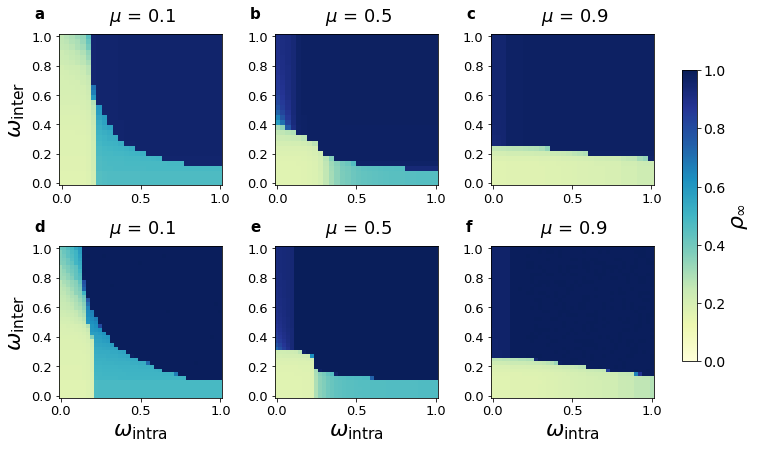

In [13]:
fig, ax1 = plt.subplots(2, 3, figsize = (12, 6))



pc1 = plot_diagram(0.1, 2.5, ax1[0, 0])
pc2 = plot_diagram(0.5, 2.5, ax1[0, 1])
pc3 = plot_diagram(0.9, 2.5, ax1[0, 2])

pc1 = plot_simu_diagram(0.1, 2.5, ax1[1, 0], N = 200000)
pc2 = plot_simu_diagram(0.5, 2.5, ax1[1, 1], N = 200000)
pc3 = plot_simu_diagram(0.9, 2.5, ax1[1, 2], N = 200000)


ax1[0, 0].text(0.3, 1.1, r"$\mu$ = 0.1", color = 'k', fontsize = 18)
ax1[0, 1].text(0.3, 1.1, r"$\mu$ = 0.5", color = 'k', fontsize = 18)
ax1[0, 2].text(0.3, 1.1, r"$\mu$ = 0.9", color = 'k', fontsize = 18)

ax1[1, 0].text(0.3, 1.1, r"$\mu$ = 0.1", color = 'k', fontsize = 18)
ax1[1, 1].text(0.3, 1.1, r"$\mu$ = 0.5", color = 'k', fontsize = 18)
ax1[1, 2].text(0.3, 1.1, r"$\mu$ = 0.9", color = 'k', fontsize = 18)

ax1[0, 0].annotate(r"a", (-0.15, 1.1), xycoords = 'axes fraction', fontsize = 15, fontweight='bold')
ax1[0, 1].annotate(r"b", (-0.15, 1.1), xycoords = 'axes fraction', fontsize = 15, fontweight='bold')
ax1[0, 2].annotate(r"c", (-0.15, 1.1), xycoords = 'axes fraction', fontsize = 15, fontweight='bold')
ax1[1, 0].annotate(r"d", (-0.15, 1.1), xycoords = 'axes fraction', fontsize = 15, fontweight='bold')
ax1[1, 1].annotate(r"e", (-0.15, 1.1), xycoords = 'axes fraction', fontsize = 15, fontweight='bold')
ax1[1, 2].annotate(r"f", (-0.15, 1.1), xycoords = 'axes fraction', fontsize = 15, fontweight='bold')

for i in range(2): # 遍历行
    for j in range(3): # 遍历列
        ax = ax1[i, j]
        if i == 0:
            ax.set_xlabel(None)
        if j > 0:
            ax.set_ylabel(None)

fig.subplots_adjust(hspace = 0.4, wspace = 0.32, left = 0.13)
    
pc = fig.colorbar(pc1, ax = ax1, shrink = 0.8, pad = 0.038)
pc.set_label(r"$\rho_\infty$", fontsize = 22)
pc.ax.tick_params(labelsize=14)

plt.savefig("appen_sfsfsf_2.5.pdf", format='pdf', bbox_inches='tight', dpi = 600);